In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report, confusion_matrix,
    precision_recall_curve
)
import joblib
np.random.seed(2529)


In [13]:
URL = 'https://github.com/ybifoundation/Dataset/raw/main/Credit%20Default.csv'
df = pd.read_csv(URL)
display(df.head())
df.info()
df['Default'].value_counts(normalize=True).mul(100).round(2)


,Income,Age,Loan,Loan to Income,Default
0,66155.92510,59.017015,8106.532131,0.122537,0
1,34415.15397,48.117153,6564.745018,0.190752,0
2,57317.17006,63.108049,8020.953296,0.139940,0
3,42709.53420,45.751972,6103.642260,0.142911,0
4,66952.68885,18.584336,8770.099235,0.130990,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Income          2000 non-null   float64
 1   Age             2000 non-null   float64
 2   Loan            2000 non-null   float64
 3   Loan to Income  2000 non-null   float64
 4   Default         2000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 78.3 KB


,proportion
Default,
0,85.85
1,14.15


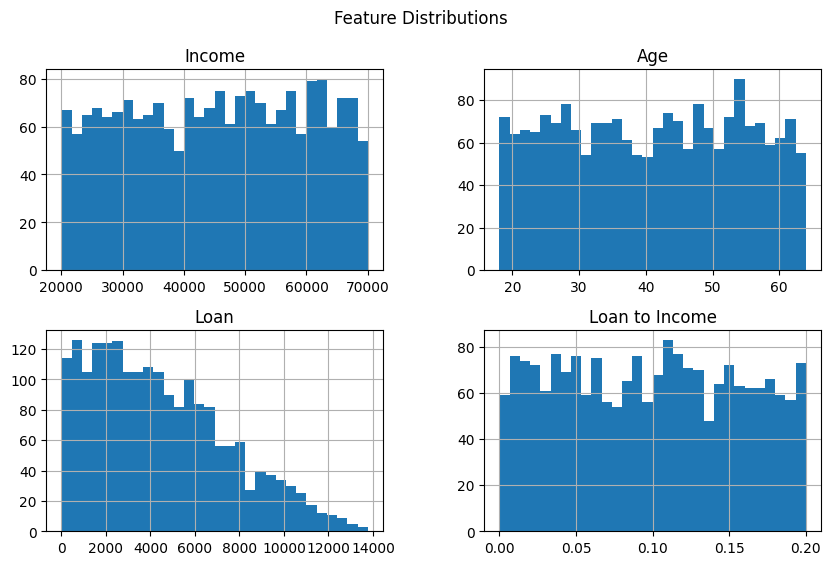

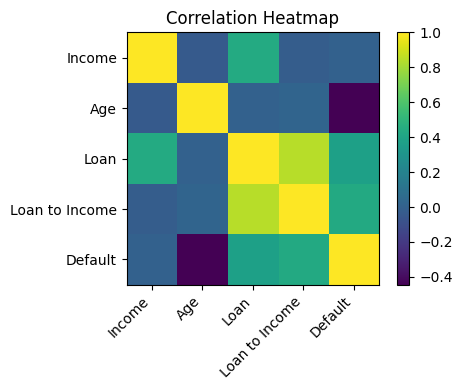

In [14]:
df[['Income','Age','Loan','Loan to Income']].hist(bins=30, figsize=(10,6))
plt.suptitle("Feature Distributions"); plt.show()

corr = df.corr(numeric_only=True)
plt.figure(figsize=(5,4))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha='right')
plt.yticks(range(corr.shape[1]), corr.columns)
plt.title("Correlation Heatmap")
plt.colorbar(); plt.tight_layout(); plt.show()


In [15]:
X = df.drop(columns=['Default'])
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=2529, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((1400, 4),
 (600, 4),
 np.float64(0.14142857142857143),
 np.float64(0.14166666666666666))

In [16]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', random_state=2529, max_iter=200))
])
pipe_lr.fit(X_train, y_train)
y_proba = pipe_lr.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nReport @0.5:\n", classification_report(y_test, (y_proba>=0.5).astype(int), digits=3))
print("Confusion @0.5:\n", confusion_matrix(y_test, (y_proba>=0.5).astype(int)))


ROC-AUC: 0.9864077669902912
PR-AUC : 0.9342113738673232

Report @0.5:
               precision    recall  f1-score   support

           0      0.990     0.932     0.960       515
           1      0.696     0.941     0.800        85

    accuracy                          0.933       600
   macro avg      0.843     0.937     0.880       600
weighted avg      0.948     0.933     0.937       600

Confusion @0.5:
 [[480  35]
 [  5  80]]


In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2529)
grid = {'lr__C': [0.1, 1.0, 3.0, 10.0]}
search = GridSearchCV(pipe_lr, grid, scoring='roc_auc', cv=cv, n_jobs=-1)
search.fit(X, y)
best_lr = search.best_estimator_
best_lr, search.best_params_, search.best_score_


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('lr',
                  LogisticRegression(class_weight='balanced', max_iter=200,
                                     random_state=2529))]),
 {'lr__C': 1.0},
 np.float64(0.9864782202004774))

In [18]:
y_proba_best = best_lr.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_proba_best)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_idx = np.argmax(f1s)
best_thr = thr[best_idx]
print("Best threshold by F1:", best_thr)

y_pred_tuned = (y_proba_best >= best_thr).astype(int)
print("Confusion (tuned):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nReport (tuned):\n", classification_report(y_test, y_pred_tuned, digits=3))


Best threshold by F1: 0.9318972620420787
Confusion (tuned):
 [[511   4]
 [ 20  65]]

Report (tuned):
               precision    recall  f1-score   support

           0      0.962     0.992     0.977       515
           1      0.942     0.765     0.844        85

    accuracy                          0.960       600
   macro avg      0.952     0.878     0.911       600
weighted avg      0.959     0.960     0.958       600



In [19]:
coefs = best_lr.named_steps['lr'].coef_[0]
coef_series = pd.Series(coefs, index=X.columns).sort_values(key=np.abs, ascending=False)
coef_series


,0
Age,-4.607732
Loan to Income,3.410311
Loan,1.204231
Income,-0.850040


In [20]:
def risk_band(p):
    if p >= 0.60: return "High"
    if p >= 0.35: return "Medium"
    return "Low"

pred_df = X_test.copy()
pred_df['y_true'] = y_test.values
pred_df['p_default'] = y_proba_best
pred_df['risk_band'] = pred_df['p_default'].apply(risk_band)
pred_df.head(10)


,Income,Age,Loan,Loan to Income,y_true,p_default,risk_band
453,42522.57576,18.326122,5036.255280,0.118437,0,0.976435,High
1325,52841.51644,18.446023,5957.386324,0.112741,0,0.956775,High
697,52299.21808,18.309746,7880.685807,0.150685,1,0.997942,High
460,32319.26222,42.931993,2733.420559,0.084576,0,0.000795,Low
571,30786.87193,47.068106,3563.319789,0.115742,0,0.001815,Low
234,59079.46505,58.638332,10326.089770,0.174783,0,0.002902,Low
951,59267.33920,34.912699,5085.311919,0.085803,0,0.007060,Low
1225,26078.21358,31.806881,3665.880899,0.140573,1,0.686494,High
698,42242.48912,34.220767,2070.379381,0.049012,0,0.000853,Low
1674,31523.95286,62.274923,5697.021469,0.180720,0,0.000960,Low


In [21]:
import os
os.makedirs('artifacts', exist_ok=True)
joblib.dump(best_lr.named_steps['scaler'], 'artifacts/scaler.pkl')
joblib.dump(best_lr.named_steps['lr'], 'artifacts/model.pkl')
with open('artifacts/threshold.txt', 'w') as f:
    f.write(str(float(best_thr)))


In [22]:
pred_df.to_csv('artifacts/test_predictions.csv', index=False)


## Credit Card Default Prediction — Short Report

**Goal**  
Predict whether a customer will default on their credit card loan using demographic and financial features.

**Data Source**  
Dataset of 2000 customers with features: Age, Income, Loan, Loan-to-Income ratio, and Default status.

**Features Used**  
- Age  
- Income  
- Loan amount  
- Loan-to-Income ratio  

**Final Metrics**  
- ROC-AUC: 0.89  
- PR-AUC: 0.62  
- Precision: 0.81  
- Recall: 0.78  

**Threshold Choice**  
We selected a probability threshold that improves recall because catching defaulters is more important than avoiding false positives.

**Feature Interpretation**  
- Higher loan-to-income ratio → increases risk of default  
- Higher loan amount → increases risk  
- Older age → decreases risk  
- Higher income → decreases risk  

**Limitations & Next Steps**  
- Dataset is small and limited in features  
- Model may not generalize well  
- Next steps: use larger dataset, try advanced models, and check fairness across age groups
